In [3]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import sys, os
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator, PoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from tf_pose.common import CocoPart, CocoPairs
import matplotlib.pyplot as plt
from PIL import Image
from plot_utils import plot_vector_field
import tensorflow as tf
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))
# Import DeepExplain
from deepexplain.tf.v1_x import DeepExplain


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using tf version = 1.15.0


In [4]:
# params 432, 368
w, h = 432, 368

image_path = '../data/images/muscle.jpg'
model = 'cmu'
resize_out_ratio = 2.0
image = common.read_imgfile(image_path, w, h)
COCO_id = CocoPart.RWrist.value
JOINT_id = 16 # right lower arm

In [5]:
e = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
# compute with and without 
humans_original = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

In [14]:

# position where to put the peak
def modify_right_wrist(estimator, pos_x = 20, pos_y = 20):
    # copy the required mats
    peaks = np.copy(estimator.peaks)
    heatMat = np.copy(estimator.heatMat)
    pafMat = np.copy(estimator.pafMat)
    eps = 0.0001

    ## CHANGE VLAUES OF THE PEAKS
    # change PAF
    # get pos of right ellow 
    elbow_x, elbow_y = np.unravel_index(peaks[:, :, CocoPart.RElbow.value].argmax(), peaks[:, :, CocoPart.RElbow.value].shape)
    print(f'elbow pos x: {elbow_x}, y: {elbow_y}')

    arm_vec = np.array([pos_x - elbow_x, pos_y - elbow_y]).astype('float64')
    arm_vec /= np.linalg.norm(arm_vec)
    print(f'armvec x: {arm_vec[0]}, y: {arm_vec[1]}')

    pafMat[:,:, JOINT_id] = np.ones(shape=pafMat.shape[:2]) * arm_vec[0]
    pafMat[:,:, JOINT_id + 1] = np.ones(shape=pafMat.shape[:2]) * arm_vec[1]

    # change heat
    cur_heat_max_val = np.max(heatMat[:,:, COCO_id])
    heatMat[:,:, COCO_id] = np.zeros(shape=peaks.shape[:2])
    heatMat[pos_y, pos_x, COCO_id] = cur_heat_max_val + eps
    
    # change peak
    cur_max = np.max(peaks[:,:, COCO_id])
    peaks[:,:, COCO_id] = np.zeros(shape=peaks.shape[:2])
    peaks[pos_y, pos_x, COCO_id] = cur_max + eps
    return peaks, heatMat, pafMat

peaks, heatMat, pafMat = modify_right_wrist(e)
humans_modified = PoseEstimator.estimate_paf(peaks, heatMat, pafMat)

elbow pos x: 30, y: 22
armvec x: -0.9805806756909202, y: -0.19611613513818404


In [15]:
part = humans_original[0].body_parts[COCO_id]
print(f'ORIG: score: {part.score} x: {part.x} y: {part.y} ')
part = humans_modified[0].body_parts[COCO_id]
print(f'OCCULED: score: {part.score} x: {part.x} y: {part.y} ')


ORIG: score: 0.8399547934532166 x: 0.32407407407407407 y: 0.3804347826086957 
OCCULED: score: 0.8400548100471497 x: 0.18518518518518517 y: 0.21739130434782608 


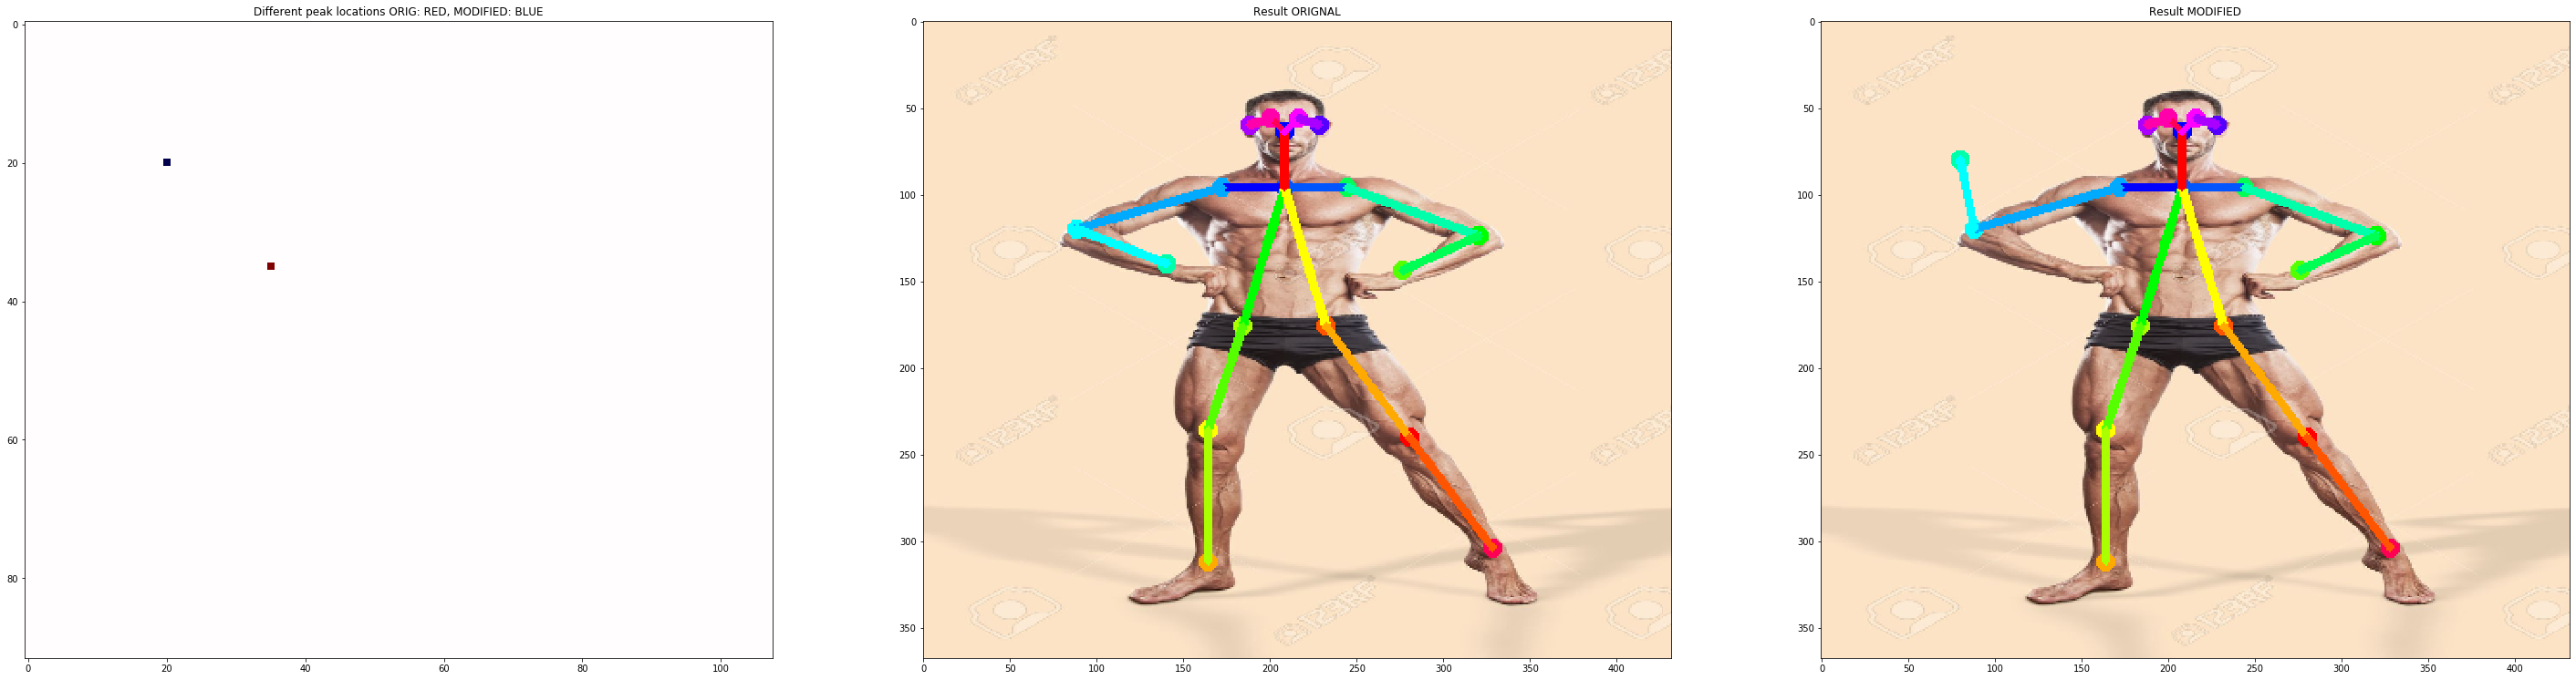

In [16]:
fig = plt.figure(figsize=(50, 25))
a = fig.add_subplot(1, 3,1)
a.set_title('Different peak locations ORIG: RED, MODIFIED: BLUE')
peak_orig = e.peaks[:, :, COCO_id]
peak_black = peaks[:, :, COCO_id]

comb_image = np.amax([peak_orig, peak_black], axis=0)
comb_image[comb_image == np.max(peak_orig)] = 1.0
comb_image[comb_image == np.max(peak_black)] = -1.0
a.imshow(comb_image, cmap=plt.cm.seismic )

#draw orig
a = fig.add_subplot(1,3,2)
image_result = TfPoseEstimator.draw_humans(image, humans_original, imgcopy=True)
a.set_title('Result ORIGNAL')
plt.imshow(cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB))

# draw modified
a = fig.add_subplot(1, 3, 3)
image_result = TfPoseEstimator.draw_humans(image, humans_modified, imgcopy=True)
a.set_title('Result MODIFIED')
plt.imshow(cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB))

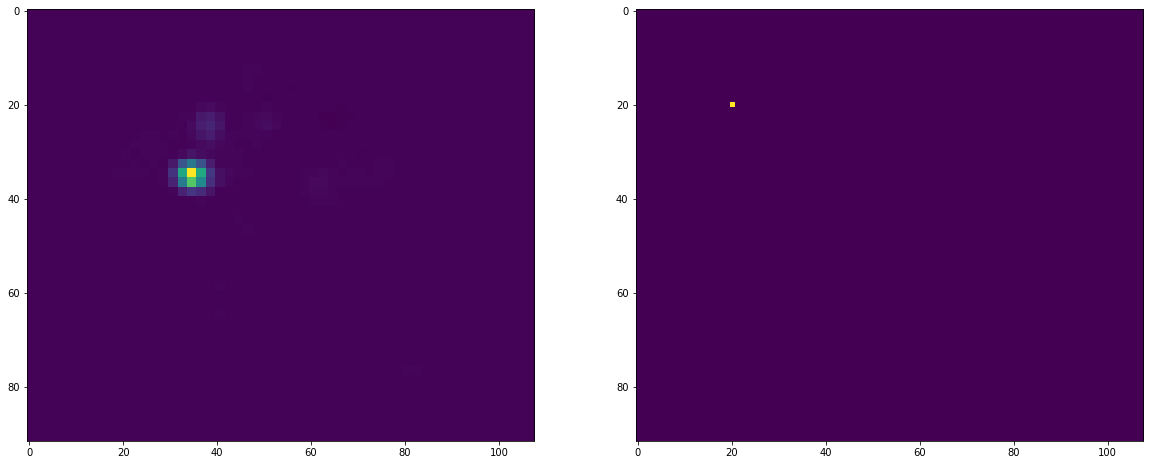

In [17]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(e.heatMat[:, :, COCO_id])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(heatMat[:, :, COCO_id])

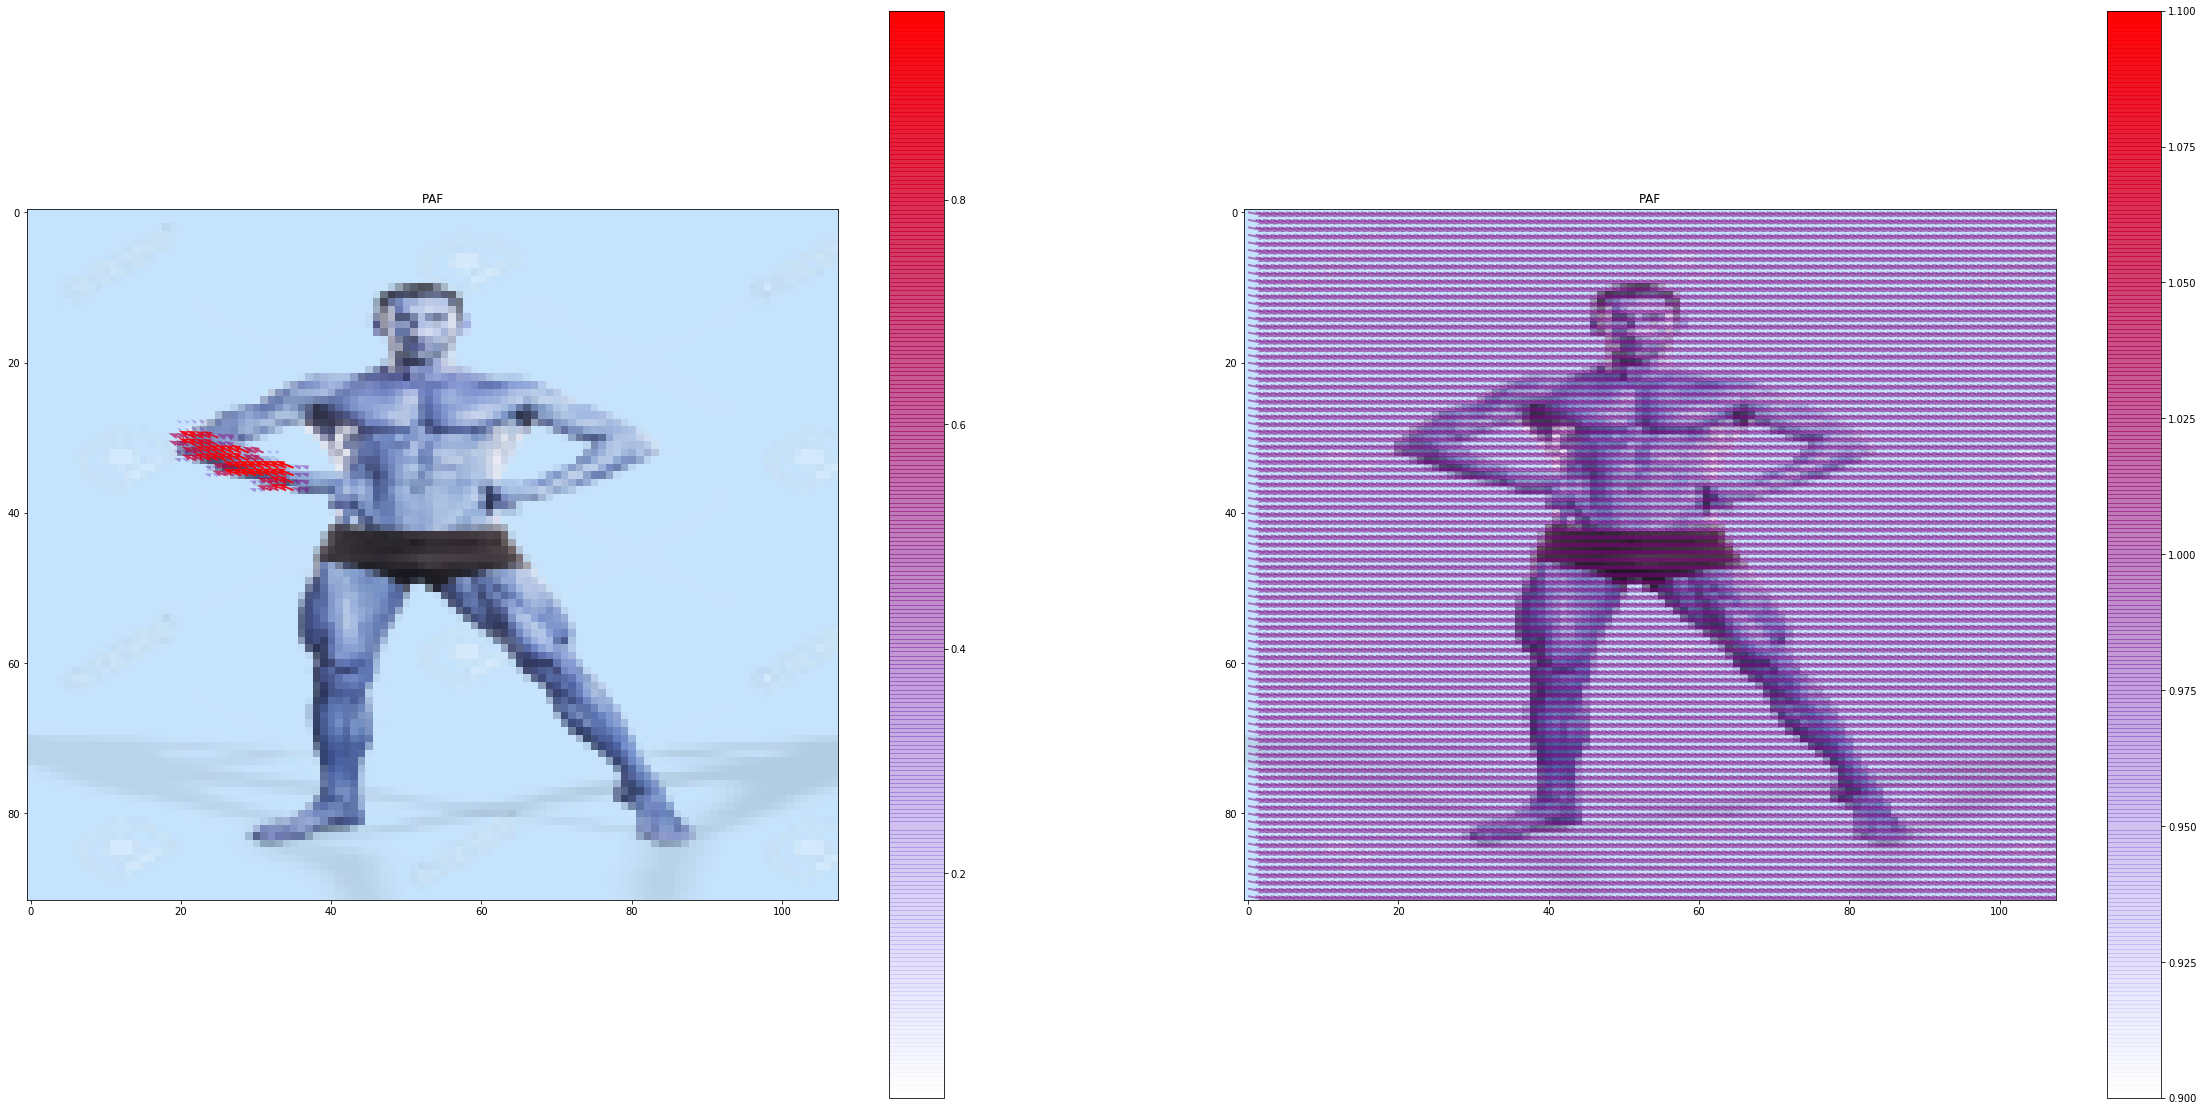

In [18]:
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(1, 2, 1)

U = np.copy(e.pafMat[:, :, JOINT_id]) * (-1) # why do I need this minus one
V = np.copy(e.pafMat[:, :, JOINT_id + 1])
bgimg = cv2.resize(image, (e.pafMat.shape[1], e.pafMat.shape[0]), interpolation=cv2.INTER_AREA)

plot_vector_field(U, V, bgimg, ax, fig)

ax = fig.add_subplot(1, 2, 2)
U = np.copy(pafMat[:, :, JOINT_id]) * (-1) # why do I need this minus one
V = np.copy(pafMat[:, :, JOINT_id + 1])
plot_vector_field(U, V, bgimg, ax, fig)
